In [1]:
#!/usr/bin/env python

import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from sklearn.datasets import make_moons
from torch import Tensor
from tqdm import tqdm
from typing import *
from zuko.utils import odeint



In [2]:

def log_normal(x: Tensor) -> Tensor:
    return -(x.square() + math.log(2 * math.pi)).sum(dim=-1) / 2


class MLP(nn.Sequential):
    def __init__(
        self,
        in_features: int,
        out_features: int,
        hidden_features: List[int] = [64, 64],
    ):
        layers = []

        for a, b in zip(
            (in_features, *hidden_features),
            (*hidden_features, out_features),
        ):
            layers.extend([nn.Linear(a, b), nn.ELU()])

        super().__init__(*layers[:-1])


class CNF(nn.Module):
    def __init__(self, features: int, freqs: int = 3, **kwargs):
        super().__init__()

        self.net = MLP(2 * freqs + features, features, **kwargs)
        self.register_buffer('freqs', torch.arange(1, freqs + 1) * torch.pi)

    def forward(self, t: Tensor, x: Tensor) -> Tensor:
        t = self.freqs * t[..., None]
        t = torch.cat((t.cos(), t.sin()), dim=-1)
        t = t.expand(*x.shape[:-1], -1)

        return self.net(torch.cat((t, x), dim=-1))

    def encode(self, x: Tensor) -> Tensor:
        return odeint(self, x, 0.0, 1.0, phi=self.parameters())

    def decode(self, z: Tensor) -> Tensor:
        return odeint(self, z, 1.0, 0.0, phi=self.parameters())

    def log_prob(self, x: Tensor) -> Tensor:
        I = torch.eye(x.shape[-1], dtype=x.dtype, device=x.device)
        I = I.expand(*x.shape, x.shape[-1]).movedim(-1, 0)

        def augmented(t: Tensor, x: Tensor, ladj: Tensor) -> Tensor:
            with torch.enable_grad():
                x = x.requires_grad_()
                dx = self(t, x)

            jacobian = torch.autograd.grad(dx, x, I, create_graph=True, is_grads_batched=True)[0]
            trace = torch.einsum('i...i', jacobian)

            return dx, trace * 1e-2

        ladj = torch.zeros_like(x[..., 0])
        z, ladj = odeint(augmented, (x, ladj), 0.0, 1.0, phi=self.parameters())

        return log_normal(z) + ladj * 1e2


class FlowMatchingLoss(nn.Module):
    def __init__(self, v: nn.Module):
        super().__init__()

        self.v = v

    def forward(self, x: Tensor) -> Tensor:
        t = torch.rand_like(x[..., 0, None])
        z = torch.randn_like(x)
        y = (1 - t) * x + (1e-4 + (1 - 1e-4) * t) * z
        u = (1 - 1e-4) * z - x

        return (self.v(t.squeeze(-1), y) - u).square().mean()



100%|█████████████████████████████████████████████| 16384/16384 [02:48<00:00, 97.33it/s]


tensor([-0.7509, -0.1315, -2.6279, -0.2889])


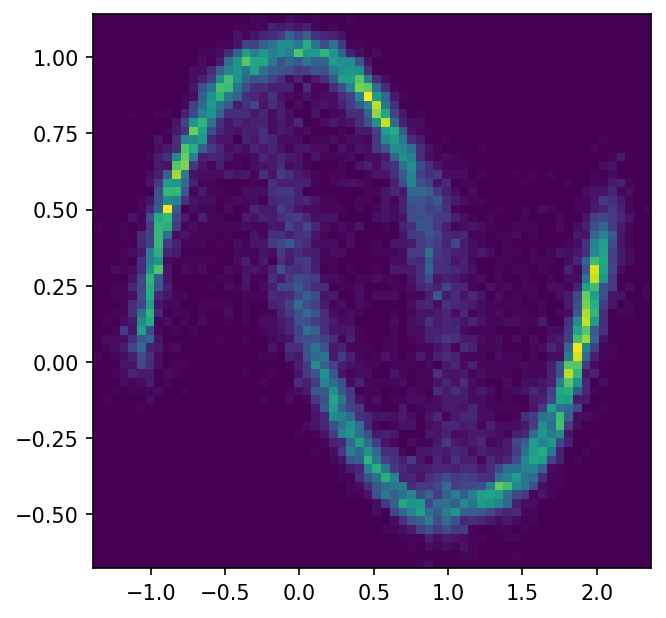

In [4]:
flow = CNF(2, hidden_features=[64] * 3)

# Training
loss = FlowMatchingLoss(flow)
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)

data, _ = make_moons(16384, noise=0.05)
data = torch.from_numpy(data).float()

for epoch in tqdm(range(16384), ncols=88):
    subset = torch.randint(0, len(data), (256,))
    x = data[subset]

    loss(x).backward()

    optimizer.step()
    optimizer.zero_grad()

# Sampling
with torch.no_grad():
    z = torch.randn(16384, 2)
    x = flow.decode(z)

plt.figure(figsize=(4.8, 4.8), dpi=150)
plt.hist2d(*x.T, bins=64)

# Log-likelihood
with torch.no_grad():
    log_p = flow.log_prob(data[:4])

print(log_p)
